<a href="https://colab.research.google.com/github/Stolas7236/MyLLMProject/blob/main/LLM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re

# 데이터 전처리 (불완)

def clean_text(filename):
    with open(filename, 'r', encoding='EUC-KR') as file:
        book_text = file.read()

        cleaned_text = re.sub(r'\n+', ' ', book_text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

        print("cleaned_" + filename, len(cleaned_text), "characters")

        with open("cleaned_" + filename, 'w', encoding='EUC-KR') as file:
            file.write(cleaned_text)

filenames_list = ["Harry Potter The Sorcerers Stone.txt"]

for filename in filenames_list:
    clean_text(filename)


In [ ]:
# 모델 정의, 데이터셋 토큰화 등..

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")

import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

with open("/content/drive/MyDrive/cleaned_dcinside_LoL_dataset_1000.txt", 'r', encoding='utf-8') as file:
    txt = file.read()

# txt = txt[:10000] # 일부만 사용

dataset = MyDataset(txt, max_length=32, stride=4)

train_loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

dataiter = iter(train_loader)

x, y = next(dataiter)

# print(tokenizer.decode(x[0].tolist()))
# print(tokenizer.decode(y[0].tolist()))

# 모델 정의

VOCAB_SIZE = len(tokenizer) # 사전의 단어가 몇개 있는지

CONTEXT_LENGTH = 128
EMB_DIM = 768
NUM_HEADS = 12
NUM_LAYERS = 12
DROP_RATE = 0.1
QKV_BIAS = False

import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)

        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

# of tokens in txt 42856


# of tokens in txt 42856
cuda
Tokens seen: 2048
Epoch: 1, Loss: 5.680037711194889
Epoch: 2, Loss: 2.5695977646433663
Epoch: 3, Loss: 0.656502814706928
Epoch: 4, Loss: 0.27201621020268535
Epoch: 5, Loss: 0.21178470123670773
Tokens seen: 2050048
Epoch: 6, Loss: 0.18868036470013463
Epoch: 7, Loss: 0.17791728487985578
Epoch: 8, Loss: 0.170587345600842
Epoch: 9, Loss: 0.16570488243045922
Epoch: 10, Loss: 0.16207451003040382


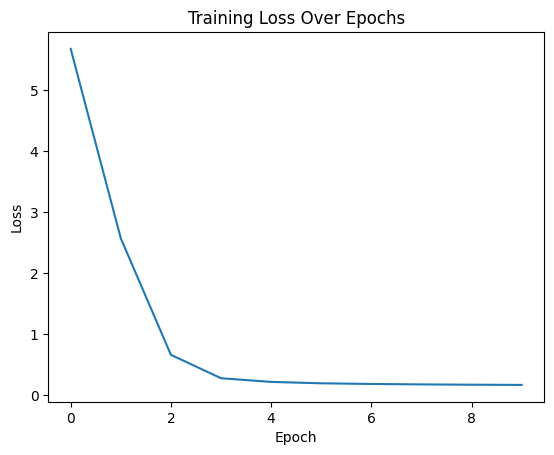

In [ ]:
# 훈련

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train() # 모델을 학습 모드로 설정

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    if epoch % 10 == 0:
      torch.save("/content/drive/MyDrive/LLM모델"+model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel()
model.to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/LLM모델/model_000.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(102400, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [ ]:
# 한 단어 예측

idx = tokenizer.encode("야")
print(idx)

idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
  logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
  print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

[1137]
5.86	 13171	  걍
5.75	 905	 가
5.71	 959	  �
5.53	 657	 는
5.53	 35422	  오너
5.48	 38040	  벽돌
5.39	 4826	  상대
5.38	 23073	  미드
5.34	 4379	  근데
5.27	 837	 �
 걍


In [ ]:
# 여러 단어 예측
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0]

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=1.5
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context: 이거 미드차이라고 생각안함?
0 : 이거 미드차이라고 생각안함? 미드 서드라고 빨으면 맛탱이까노 티원 도오긴 하네 티원의 오너, 도란 좆란 버스 타라고 해서 못벌지 24년 5 t년동안지 상이 지는거지 애초에
1 : 이거 미드차이라고 생각안함?면 구맘으로 다 지는거 보고가 다란 바지적의뇌해서 못굴 응줌이되네 코로나 걍 스카웃진이긴한게 나가던은거 본을거였으면서 상혁인데 오늘 경기 미드은
2 : 이거 미드차이라고 생각안함? 씨발 역시 분당 네임콜 미드 둘다 이런 애들에 제오구케 페이즈 씨발 뒷닌진인거라서 비가면 너는 진짜 티응임 오늘 개좆 페이커 비디 퍼펙트는 라인전도보다 즙 경기는
3 : 이거 미드차이라고 생각안함?임 미드라이너한거아님 한화는거 아님 도란인데 농심으로 못하고 살아돌아오는새끼가없고 슼 2대으면 라인전 반반가없음 젠지이냐 구좆이 그미드브하고,가 T
4 : 이거 미드차이라고 생각안함?중 구마유시네요 아는 구마 오너가 딱 도오비 비빌려는 걍 승점드컵있으니 근데 오늘 걍 반반에서 미드퍼펙트던 그와도 못치니까 티원의도 이 과정은 것도 개�
5 : 이거 미드차이라고 생각안함?하던 케리아도 그렇다고 2 도오은 도란은 왜 말던 거 같긴 한데 그냥 칼릭스가 존나서 버티아서인데 쵸비정도라도은데 도란 정글은 진짜 페이커리어라 슼있라고
6 : 이거 미드차이라고 생각안함?하고 페이커를 충족는데 라인전 실력이 없다주음 오늘서 월즈 전으로 개패니까 평소대로 한타령하니까 도란에서 티원은 나중해줘어서 그냥 사이드 1 월 확정인분에서
7 : 이거 미드차이라고 생각안함?의 오늘 비디 구마한 놈이 복귀 방송중인데 수위 캐리력이었음 팀 제카가 쵸비 이말이가 안된리고있네 구맘임 걍 페이커인데 걍 원클럽5 한화랑이 지어서 그냥 라인
8 : 이거 미드차이라고 생각안함?대서 오늘 티하던거 다 밀어 안� 쮀어야지 라인전도르게 눈나는걸로 더 하니까 많음 그리고 로고는데 티원도 모르리는 손목이긴 한데이라니까 급음 젠지가
9 : 이거 미드차이라고 생각안함?경기때부터 슼 카운